<a href="https://colab.research.google.com/github/ykitaguchi77/POLAR/blob/main/Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

device:cuda  batch:256  epochs:50  warmup:4  conf_thresh:0.8
[epoch 1] loss:2.0660  test_acc:0.5868
[epoch 2] loss:1.6684  test_acc:0.6774
[epoch 3] loss:1.4304  test_acc:0.7027
[epoch 4] loss:1.2747  test_acc:0.7320
[epoch 5] loss:1.1932  test_acc:0.7468
[epoch 6] loss:1.1117  test_acc:0.7605
[epoch 7] loss:1.0474  test_acc:0.7704
[epoch 8] loss:0.9956  test_acc:0.7768
[epoch 9] loss:0.9526  test_acc:0.7846
[epoch 10] loss:0.9163  test_acc:0.7905
[epoch 11] loss:0.8851  test_acc:0.7953
[epoch 12] loss:0.8580  test_acc:0.8015
[epoch 13] loss:0.8341  test_acc:0.8033
[epoch 14] loss:0.8129  test_acc:0.8090
[epoch 15] loss:0.7937  test_acc:0.8134
[epoch 16] loss:0.7765  test_acc:0.8166
[epoch 17] loss:0.7608  test_acc:0.8193
[epoch 18] loss:0.7465  test_acc:0.8216
[epoch 19] loss:0.7334  test_acc:0.8248
[epoch 20] loss:0.7212  test_acc:0.8271
[epoch 21] loss:0.7099  test_acc:0.8299
[epoch 22] loss:0.6993  test_acc:0.8321
[epoch 23] loss:0.6896  test_acc:0.8344
[epoch 24] loss:0.6804  test

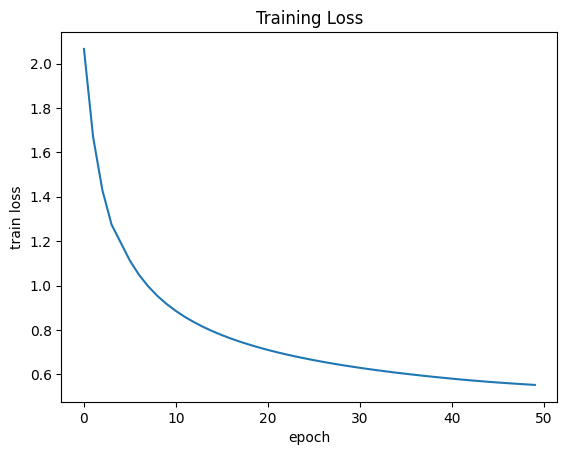

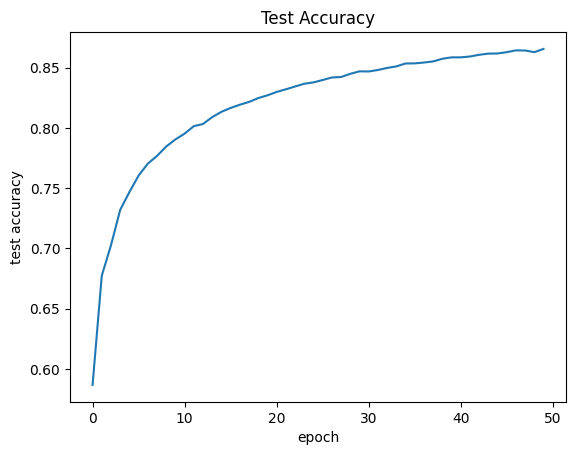

In [ ]:
# @title MNIST: 逆伝播なし（プロトタイプ局所学習）安定版v3：正規化MSE + 適応ランプ + クリップ
import math, time, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ===== ハイパラ =====
use_cuda_if_available = True
epochs = 50
warmup_epochs = 4
batch_size = 256

lr_w = 2e-4                     # 中間層（小さめ）
lr_out = 1e-2                   # 出力層（強め）
proto_momentum = 0.99
lam_hidden_max = (0.2, 0.2, 0.2) # 最大係数はやや上げる（適応で自動減衰）
conf_thresh = 0.80              # 信頼度ゲート下限
clip_norm = 1.0                 # 中間層勾配クリップ（L2ノルム）

seed = 42
torch.manual_seed(seed); np.random.seed(seed)
device = "cuda" if (use_cuda_if_available and torch.cuda.is_available()) else "cpu"
torch.set_grad_enabled(False)

# ===== モデル =====
class LocalConv(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, stride=1, padding=1):
        super().__init__()
        self.W = nn.Parameter(torch.empty(out_ch, in_ch, k, k))
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        self.stride, self.padding = stride, padding
        self.norm = nn.GroupNorm(1, out_ch)
    def forward(self, a_prev):
        z = F.conv2d(a_prev, self.W, stride=self.stride, padding=self.padding)
        z = self.norm(z); a = F.relu(z)
        return z, a

class LocalFC(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.empty(out_dim, in_dim))
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        self.norm = nn.LayerNorm(out_dim)
    def forward(self, a_prev):
        z = F.linear(a_prev, self.W)
        z = self.norm(z); a = F.relu(z)
        return z, a

class Net(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = LocalConv(1, 32, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = LocalConv(32, 64, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1   = LocalFC(64*7*7, 128)
        self.out   = nn.Linear(128, n_classes, bias=False)
    def forward(self, x):
        z1, a1 = self.conv1(x); a1p = self.pool1(a1)
        z2, a2 = self.conv2(a1p); a2p = self.pool2(a2)
        a2f = a2p.reshape(a2p.size(0), -1)
        z3, a3 = self.fc1(a2f)
        logits = self.out(a3)
        return (z1, z2, z3), (x, a1, a1p, a2, a2p, a2f, a3), logits

# ===== プロトタイプ =====
class ProtoBank:
    def __init__(self, dims, n_classes=10, momentum=0.99, device="cpu"):
        self.m = momentum
        self.P = {k: torch.zeros(n_classes, d, device=device) for k, d in dims.items()}
        self.init = {k: torch.zeros(n_classes, dtype=torch.bool, device=device) for k in dims.keys()}
    @torch.no_grad()
    def _upd(self, key, feats, y):
        Pk, Ik = self.P[key], self.init[key]
        for c in y.unique():
            c0 = int(c)
            m = (y==c)
            mu = feats[m].mean(0)
            if not Ik[c0]:
                Pk[c0] = mu; Ik[c0] = True
            else:
                Pk[c0] = self.m * Pk[c0] + (1 - self.m) * mu
        return Pk[y]
    def conv_target(self, key, Z, y):
        return self._upd(key, Z.mean((2,3)), y).unsqueeze(-1).unsqueeze(-1).expand_as(Z)
    def fc_target(self, key, Z, y):
        return self._upd(key, Z, y)

# ===== 正規化MSE（scale-invariant） =====
def norm_mse(Z, U, dims):
    # L2正規化（小さすぎるノルムは抑止）
    eps = 1e-6
    if len(Z.shape)==4:  # conv: [B,C,H,W] -> 正規化はC次元で
        Zn = Z / (Z.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
        Un = U / (U.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
    else:                # fc: [B,D] -> D次元で
        Zn = Z / (Z.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
        Un = U / (U.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
    E = Zn - Un
    L = 0.5 * (E.pow(2).mean())
    return E, L

# ===== 適応ランプ（バッチ毎） =====
def adaptive_lambda(ep, warmup_epochs, lam_max, conf_mean, ce_improve):
    """
    conf_mean: そのバッチの平均 max softmax
    ce_improve: 直近のCEが改善（負なら悪化）
    """
    if ep <= warmup_epochs:
        return 0.0
    # 自信と改善が高いほど係数アップ（0〜1に収める）
    c = max(0.0, (conf_mean - 0.75) / (1.0 - 0.75))  # 0.75から1.0へ線形
    g = 1.0 if ce_improve < 0 else 0.5               # 改善時=1, 悪化時=0.5
    base = c * g
    return lam_max * base

def grad_clip_(W, G, max_norm):
    # Gのノルムでスケールダウン
    if max_norm is None or max_norm <= 0:
        return G
    gnorm = torch.linalg.vector_norm(G)
    if gnorm > max_norm:
        G = G * (max_norm / (gnorm + 1e-12))
    return G

def lambda_schedule_epoch(ep, start_ep, end_ep, max_lambda):
    if ep <= start_ep: return 0.0
    if ep >= end_ep:   return max_lambda
    t = (ep - start_ep) / max(1, (end_ep - start_ep))
    return max_lambda * t

@torch.no_grad()
def train_step(model, protos, feats, zs, y, lr_w, lr_out,
               ep, warmup_epochs, lam_hidden_max, conf_thresh,
               prev_ce_avg=None):
    (z1, z2, z3) = zs
    (x, a1, a1p, a2, a2p, a2f, a3) = feats

    # --- 出力層: CE（手動勾配） ---
    logits = model.out(a3)
    prob = F.softmax(logits, dim=1)
    onehot = F.one_hot(y, num_classes=logits.shape[1]).float().to(logits.device)
    ce_val = F.cross_entropy(logits, y).item()
    grad_logits = (prob - onehot) / logits.shape[0]
    dW_out = grad_logits.T @ a3
    model.out.weight.data.add_(-lr_out * dW_out)

    # プロトタイプ更新（常時）
    _ = protos.conv_target("c1", z1, y)
    _ = protos.conv_target("c2", z2, y)
    _ = protos.fc_target ("fc1", z3, y)

    if ep <= warmup_epochs:
        return ce_val, logits, ce_val  # ce_avgを返して次バッチの比較に使う

    # バッチ信頼度とCE改善
    conf_mean = prob.max(1).values.mean().item()
    ce_improve = ce_val - (prev_ce_avg if prev_ce_avg is not None else ce_val)

    # 各層の適応係数（エポックRamp × バッチ適応）
    lam1_max = lambda_schedule_epoch(ep, warmup_epochs, warmup_epochs+3, lam_hidden_max[0])
    lam2_max = lambda_schedule_epoch(ep, warmup_epochs, warmup_epochs+3, lam_hidden_max[1])
    lam3_max = lambda_schedule_epoch(ep, warmup_epochs, warmup_epochs+3, lam_hidden_max[2])
    lam1 = adaptive_lambda(ep, warmup_epochs, lam1_max, conf_mean, ce_improve)
    lam2 = adaptive_lambda(ep, warmup_epochs, lam2_max, conf_mean, ce_improve)
    lam3 = adaptive_lambda(ep, warmup_epochs, lam3_max, conf_mean, ce_improve)

    # 信頼度ゲート（サンプル選別）
    conf = prob.max(dim=1).values
    mask = (conf >= conf_thresh).float()
    if mask.sum() < 1:
        return ce_val, logits, (0.9*prev_ce_avg + 0.1*ce_val) if prev_ce_avg is not None else ce_val
    mask_c1 = mask.view(-1,1,1,1); mask_c2 = mask.view(-1,1,1,1); mask_fc = mask.view(-1,1)

    # conv1（入力は x）: 正規化MSE
    U1 = protos.conv_target("c1", z1, y)
    E1n, L1 = norm_mse(z1, U1, dims=(0,2,3))
    E1n = E1n * mask_c1
    dW1 = torch.nn.grad.conv2d_weight(x, model.conv1.W.shape, (lam1 * E1n) / max(1, int(mask.sum())),
                                      stride=model.conv1.stride, padding=model.conv1.padding)
    dW1 = grad_clip_(model.conv1.W, dW1, clip_norm)
    model.conv1.W.add_(-lr_w * dW1)

    # conv2（入力は a1p）: 正規化MSE
    U2 = protos.conv_target("c2", z2, y)
    E2n, L2 = norm_mse(z2, U2, dims=(0,2,3))
    E2n = E2n * mask_c2
    dW2 = torch.nn.grad.conv2d_weight(a1p, model.conv2.W.shape, (lam2 * E2n) / max(1, int(mask.sum())),
                                      stride=model.conv2.stride, padding=model.conv2.padding)
    dW2 = grad_clip_(model.conv2.W, dW2, clip_norm)
    model.conv2.W.add_(-lr_w * dW2)

    # fc1: 正規化MSE
    U3 = protos.fc_target("fc1", z3, y)
    E3n, L3 = norm_mse(z3, U3, dims=(0,))
    E3n = E3n * mask_fc
    dW3 = ((lam3 * E3n) / max(1, int(mask.sum()))).T @ a2f
    dW3 = grad_clip_(model.fc1.W, dW3, clip_norm)
    model.fc1.W.add_(-lr_w * dW3)

    total = ce_val + L1.item() + L2.item() + L3.item()
    ce_avg = (0.9*prev_ce_avg + 0.1*ce_val) if prev_ce_avg is not None else ce_val
    return total, logits, ce_avg

def eval_accuracy(model, loader, device):
    correct = total = 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        _, _, logits = model(x)
        pred = logits.argmax(1)
        correct += (pred.cpu() == y).sum().item()
        total += y.size(0)
    return correct / total

# ===== データ =====
tfm = transforms.ToTensor()
train_ds = datasets.MNIST(root="/content/data", train=True, download=True, transform=tfm)
test_ds  = datasets.MNIST(root="/content/data", train=False, download=True, transform=tfm)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2,
                          pin_memory=(device=="cuda"))
test_loader  = DataLoader(test_ds, batch_size=512, shuffle=False, num_workers=2,
                          pin_memory=(device=="cuda"))

# ===== 準備 =====
n_classes = 10
model = Net(n_classes=n_classes).to(device)
protos = ProtoBank({"c1":32,"c2":64,"fc1":128}, n_classes=n_classes, momentum=proto_momentum, device=device)

# ===== 学習 =====
hist = {"train_loss": [], "test_acc": []}
print(f"device:{device}  batch:{batch_size}  epochs:{epochs}  warmup:{warmup_epochs}  conf_thresh:{conf_thresh}")
t0 = time.time()
ce_avg = None
for ep in range(1, epochs+1):
    running_loss, n = 0.0, 0
    for x, y in train_loader:
        x = x.to(device, non_blocking=True); y = y.to(device)
        zs, feats, logits = model(x)
        loss_batch, _, ce_avg = train_step(
            model, protos, feats, zs, y,
            lr_w=lr_w, lr_out=lr_out,
            ep=ep, warmup_epochs=warmup_epochs,
            lam_hidden_max=lam_hidden_max, conf_thresh=conf_thresh,
            prev_ce_avg=ce_avg
        )
        running_loss += loss_batch * x.size(0); n += x.size(0)
    train_loss = running_loss / n
    test_acc = eval_accuracy(model, test_loader, device)
    hist["train_loss"].append(train_loss); hist["test_acc"].append(test_acc)
    print(f"[epoch {ep}] loss:{train_loss:.4f}  test_acc:{test_acc:.4f}")

print(f"done. elapsed: {time.time()-t0:.1f}s")

plt.figure(); plt.plot(hist["train_loss"]); plt.xlabel("epoch"); plt.ylabel("train loss"); plt.title("Training Loss"); plt.show()
plt.figure(); plt.plot(hist["test_acc"]); plt.xlabel("epoch"); plt.ylabel("test accuracy"); plt.title("Test Accuracy"); plt.show()


In [ ]:
# MNIST: 逆伝播なし（プロトタイプ局所学習）安定版 v4
import math, time, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ===== ハイパラ =====
use_cuda_if_available = True
epochs = 50
warmup_epochs = 4
batch_size = 256

lr_w = 2e-4                     # 中間層（小さめ）
lr_out = 1e-2                   # 出力層（強め）
proto_momentum = 0.99
lam_hidden_max = (0.2, 0.2, 0.2)
conf_thresh = 0.80              # 信頼度ゲート
cos_thresh = 0.20               # 追加: プロトタイプとのcos類似度ゲート（0〜1）。0.2〜0.4が目安
clip_norm = 1.0                 # 中間層勾配クリップ（L2ノルム）
temp_eval = 1.2                 # 追加: 評価時の温度（過信抑制）
use_ema_eval = True             # 追加: EMAで評価

seed = 42
torch.manual_seed(seed); np.random.seed(seed)
device = "cuda" if (use_cuda_if_available and torch.cuda.is_available()) else "cpu"
torch.set_grad_enabled(False)
# （必要なら）再現性を高める
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# ===== モデル =====
class LocalConv(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, stride=1, padding=1):
        super().__init__()
        self.W = nn.Parameter(torch.empty(out_ch, in_ch, k, k))
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        self.stride, self.padding = stride, padding
        self.norm = nn.GroupNorm(1, out_ch)
    def forward(self, a_prev):
        z_pre = F.conv2d(a_prev, self.W, stride=self.stride, padding=self.padding)
        z = self.norm(z_pre)
        a = F.relu(z)
        return z, a

class LocalFC(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.empty(out_dim, in_dim))
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        self.norm = nn.LayerNorm(out_dim)
    def forward(self, a_prev):
        z_pre = F.linear(a_prev, self.W)
        z = self.norm(z_pre)
        a = F.relu(z)
        return z, a

class Net(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = LocalConv(1, 32, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = LocalConv(32, 64, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1   = LocalFC(64*7*7, 128)
        self.out   = nn.Linear(128, n_classes, bias=False)
    def forward(self, x):
        z1, a1 = self.conv1(x); a1p = self.pool1(a1)
        z2, a2 = self.conv2(a1p); a2p = self.pool2(a2)
        a2f = a2p.reshape(a2p.size(0), -1)
        z3, a3 = self.fc1(a2f)
        logits = self.out(a3)
        return (z1, z2, z3), (x, a1, a1p, a2, a2p, a2f, a3), logits

# ===== プロトタイプ =====
class ProtoBank:
    def __init__(self, dims, n_classes=10, momentum=0.99, device="cpu"):
        self.m = momentum
        self.P = {k: torch.zeros(n_classes, d, device=device) for k, d in dims.items()}
        self.init = {k: torch.zeros(n_classes, dtype=torch.bool, device=device) for k in dims.keys()}
    @torch.no_grad()
    def _upd(self, key, feats, y):
        Pk, Ik = self.P[key], self.init[key]
        for c in y.unique():
            c0 = int(c)
            m = (y==c)
            mu = feats[m].mean(0)
            if not Ik[c0]:
                Pk[c0] = mu; Ik[c0] = True
            else:
                Pk[c0] = self.m * Pk[c0] + (1 - self.m) * mu
        return Pk[y]
    def conv_target(self, key, Z, y):
        return self._upd(key, Z.mean((2,3)), y).unsqueeze(-1).unsqueeze(-1).expand_as(Z)
    def fc_target(self, key, Z, y):
        return self._upd(key, Z, y)

# ===== 正規化MSE（scale-invariant） + ReLU近似勾配 =====
def norm_mse_with_relu_mask(Z, U, z_for_mask):
    eps = 1e-6
    if Z.ndim == 4:
        Zn = Z / (Z.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
        Un = U / (U.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
        relu_mask = (z_for_mask > 0).float()
    else:
        Zn = Z / (Z.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
        Un = U / (U.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
        relu_mask = (z_for_mask > 0).float()
    E = (Zn - Un) * relu_mask
    L = 0.5 * (E.pow(2).mean())
    return E, L

# ===== 適応ランプ（バッチ毎） =====
def adaptive_lambda(ep, warmup_epochs, lam_max, conf_mean, ce_improve):
    if ep <= warmup_epochs:
        return 0.0
    c = max(0.0, (conf_mean - 0.75) / (1.0 - 0.75))
    g = 1.0 if ce_improve < 0 else 0.5
    base = c * g
    return lam_max * base

def grad_clip_(G, max_norm):
    if max_norm is None or max_norm <= 0:
        return G
    gnorm = torch.linalg.vector_norm(G)
    if gnorm > max_norm:
        G = G * (max_norm / (gnorm + 1e-12))
    return G

def lambda_schedule_epoch(ep, start_ep, end_ep, max_lambda):
    if ep <= start_ep: return 0.0
    if ep >= end_ep:   return max_lambda
    t = (ep - start_ep) / max(1, (end_ep - start_ep))
    return max_lambda * t

@torch.no_grad()
def cosine_similarity(a, b, dim=1, eps=1e-8):
    an = a / (a.norm(dim=dim, keepdim=True).clamp_min(eps))
    bn = b / (b.norm(dim=dim, keepdim=True).clamp_min(eps))
    return (an * bn).sum(dim=dim)

@torch.no_grad()
def train_step(model, protos, feats, zs, y, lr_w, lr_out,
               ep, warmup_epochs, lam_hidden_max, conf_thresh, cos_thresh,
               prev_ce_avg=None):
    (z1, z2, z3) = zs
    (x, a1, a1p, a2, a2p, a2f, a3) = feats

    # --- 出力層: CE（手動勾配） ---
    logits = model.out(a3)                 # ここでのみ使用（更新は直後）
    prob = F.softmax(logits, dim=1)
    onehot = F.one_hot(y, num_classes=logits.shape[1]).float().to(logits.device)
    ce_val = F.cross_entropy(logits, y).item()
    grad_logits = (prob - onehot) / logits.shape[0]
    dW_out = grad_logits.T @ a3
    model.out.weight.data.add_(-lr_out * dW_out)

    # プロトタイプ更新（常時）
    U1 = protos.conv_target("c1", z1, y)
    U2 = protos.conv_target("c2", z2, y)
    U3 = protos.fc_target ("fc1", z3, y)

    if ep <= warmup_epochs:
        return ce_val, logits, ce_val

    # バッチ信頼度＆CE改善
    conf_mean = prob.max(1).values.mean().item()
    ce_improve = ce_val - (prev_ce_avg if prev_ce_avg is not None else ce_val)

    # エポックRamp × バッチ適応
    lam1_max = lambda_schedule_epoch(ep, warmup_epochs, warmup_epochs+3, lam_hidden_max[0])
    lam2_max = lambda_schedule_epoch(ep, warmup_epochs, warmup_epochs+3, lam_hidden_max[1])
    lam3_max = lambda_schedule_epoch(ep, warmup_epochs, warmup_epochs+3, lam_hidden_max[2])
    lam1 = adaptive_lambda(ep, warmup_epochs, lam1_max, conf_mean, ce_improve)
    lam2 = adaptive_lambda(ep, warmup_epochs, lam2_max, conf_mean, ce_improve)
    lam3 = adaptive_lambda(ep, warmup_epochs, lam3_max, conf_mean, ce_improve)

    # --- 二重ゲート: softmax信頼度 + cos類似度 ---
    with torch.no_grad():
        conf = prob.max(dim=1).values
        cos1 = cosine_similarity(z1.mean((2,3)), U1.mean((2,3)), dim=1)
        cos2 = cosine_similarity(z2.mean((2,3)), U2.mean((2,3)), dim=1)
        cos3 = cosine_similarity(z3,              U3,               dim=1)
        cos_ok = ((cos1 > cos_thresh) & (cos2 > cos_thresh) & (cos3 > cos_thresh)).float()
        mask = ((conf >= conf_thresh).float() * cos_ok)
    if mask.sum() < 1:
        ce_avg = (0.9*prev_ce_avg + 0.1*ce_val) if prev_ce_avg is not None else ce_val
        return ce_val, logits, ce_avg

    mask_c = mask.view(-1,1,1,1)
    mask_fc = mask.view(-1,1)

    # --- conv1 更新（ReLU近似マスク入り正規化MSE）
    E1n, L1 = norm_mse_with_relu_mask(z1, U1, z_for_mask=z1)
    E1n = E1n * mask_c
    grad_like_1 = (lam1 * E1n) / max(1, int(mask.sum()))
    dW1 = torch.nn.grad.conv2d_weight(x, model.conv1.W.shape, grad_like_1,
                                      stride=model.conv1.stride, padding=model.conv1.padding)
    dW1 = grad_clip_(dW1, clip_norm)
    model.conv1.W.add_(-lr_w * dW1)

    # --- conv2 更新
    E2n, L2 = norm_mse_with_relu_mask(z2, U2, z_for_mask=z2)
    E2n = E2n * mask_c
    grad_like_2 = (lam2 * E2n) / max(1, int(mask.sum()))
    dW2 = torch.nn.grad.conv2d_weight(a1p, model.conv2.W.shape, grad_like_2,
                                      stride=model.conv2.stride, padding=model.conv2.padding)
    dW2 = grad_clip_(dW2, clip_norm)
    model.conv2.W.add_(-lr_w * dW2)

    # --- fc1 更新
    E3n, L3 = norm_mse_with_relu_mask(z3, U3, z_for_mask=z3)
    E3n = E3n * mask_fc
    dW3 = ((lam3 * E3n) / max(1, int(mask.sum()))).T @ a2f
    dW3 = grad_clip_(dW3, clip_norm)
    model.fc1.W.add_(-lr_w * dW3)

    total = ce_val + L1.item() + L2.item() + L3.item()
    ce_avg = (0.9*prev_ce_avg + 0.1*ce_val) if prev_ce_avg is not None else ce_val
    return total, logits, ce_avg

# ===== EMA モデル =====
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = [p.detach().clone() for p in model.parameters()]
        self.params = [p for p in model.parameters()]
    @torch.no_grad()
    def update(self):
        for s, p in zip(self.shadow, self.params):
            s.mul_(self.decay).add_(p, alpha=(1.0 - self.decay))
    @torch.no_grad()
    def to_model(self, model):
        for s, p in zip(self.shadow, model.parameters()):
            p.copy_(s)

@torch.inference_mode()
def eval_accuracy(model, loader, device, T=1.0):
    correct = total = 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        _, _, logits = model(x)
        if T != 1.0:
            logits = logits / T
        pred = logits.argmax(1).cpu()
        correct += (pred == y).sum().item()
        total += y.size(0)
    return correct / total

# ===== データ =====
tfm = transforms.ToTensor()
train_ds = datasets.MNIST(root="/content/data", train=True, download=True, transform=tfm)
test_ds  = datasets.MNIST(root="/content/data", train=False, download=True, transform=tfm)
pinmem = (device=="cuda")
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=pinmem)
test_loader  = DataLoader(test_ds,  batch_size=512,    shuffle=False, num_workers=2, pin_memory=pinmem)

# ===== 準備 =====
n_classes = 10
model = Net(n_classes=n_classes).to(device)
ema = EMA(model, decay=0.999) if use_ema_eval else None
protos = ProtoBank({"c1":32,"c2":64,"fc1":128}, n_classes=n_classes, momentum=proto_momentum, device=device)

# ===== 学習 =====
hist = {"train_loss": [], "test_acc": []}
print(f"device:{device}  batch:{batch_size}  epochs:{epochs}  warmup:{warmup_epochs}  conf_thresh:{conf_thresh}  cos_thresh:{cos_thresh}")
t0 = time.time()
ce_avg = None
for ep in range(1, epochs+1):
    running_loss, n = 0.0, 0
    for x, y in train_loader:
        x = x.to(device, non_blocking=True); y = y.to(device)
        zs, feats, _ = model(x)
        loss_batch, _, ce_avg = train_step(
            model, protos, feats, zs, y,
            lr_w=lr_w, lr_out=lr_out,
            ep=ep, warmup_epochs=warmup_epochs,
            lam_hidden_max=lam_hidden_max, conf_thresh=conf_thresh, cos_thresh=cos_thresh,
            prev_ce_avg=ce_avg
        )
        running_loss += loss_batch * x.size(0); n += x.size(0)
        if use_ema_eval: ema.update()
    train_loss = running_loss / n

    # 評価は EMA（あれば）＋ 温度スケーリング
    if use_ema_eval:
        backup = [p.detach().clone() for p in model.parameters()]
        ema.to_model(model)
        test_acc = eval_accuracy(model, test_loader, device, T=temp_eval)
        # 元に戻す
        for p, b in zip(model.parameters(), backup): p.copy_(b)
    else:
        test_acc = eval_accuracy(model, test_loader, device, T=temp_eval)

    hist["train_loss"].append(train_loss); hist["test_acc"].append(test_acc)
    print(f"[epoch {ep}] loss:{train_loss:.4f}  test_acc:{test_acc:.4f}")

print(f"done. elapsed: {time.time()-t0:.1f}s")

plt.figure(); plt.plot(hist["train_loss"]); plt.xlabel("epoch"); plt.ylabel("train loss"); plt.title("Training Loss"); plt.show()
plt.figure(); plt.plot(hist["test_acc"]); plt.xlabel("epoch"); plt.ylabel("test accuracy"); plt.title("Test Accuracy"); plt.show()


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.23MB/s]


device:cuda  batch:256  epochs:50  warmup:4  conf_thresh:0.8  cos_thresh:0.2
[epoch 1] loss:2.0660  test_acc:0.1253
[epoch 2] loss:1.6684  test_acc:0.3004
[epoch 3] loss:1.4304  test_acc:0.5018
[epoch 4] loss:1.2747  test_acc:0.6104
[epoch 5] loss:1.1893  test_acc:0.6739
[epoch 6] loss:1.1077  test_acc:0.7100
[epoch 7] loss:1.0434  test_acc:0.7326
[epoch 8] loss:0.9916  test_acc:0.7484
[epoch 9] loss:0.9486  test_acc:0.7596
[epoch 10] loss:0.9123  test_acc:0.7669
[epoch 11] loss:0.8811  test_acc:0.7741
[epoch 12] loss:0.8540  test_acc:0.7824
[epoch 13] loss:0.8301  test_acc:0.7890
[epoch 14] loss:0.8089  test_acc:0.7935
[epoch 15] loss:0.7897  test_acc:0.7970
[epoch 16] loss:0.7725  test_acc:0.8022
[epoch 17] loss:0.7568  test_acc:0.8064
[epoch 18] loss:0.7425  test_acc:0.8106
[epoch 19] loss:0.7294  test_acc:0.8143
[epoch 20] loss:0.7172  test_acc:0.8166
[epoch 21] loss:0.7059  test_acc:0.8193
[epoch 22] loss:0.6953  test_acc:0.8226
[epoch 23] loss:0.6856  test_acc:0.8253
[epoch 24] l

In [ ]:
# MNIST: 逆伝播なし（プロトタイプ局所学習）
# 出力層の最適化にAdamWを導入
# 速さ最優先：GPU常駐データ＋軽量GPU Aug＋隠れ層の間引き更新＋評価間引き
import math, time, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ===== ハイパラ =====
use_cuda_if_available = True
epochs = 500
batch_size = 1024
hidden_update_every = 2
eval_every = 5
early_stopping_patience = 25

# --- 学習率スケジューラ ---
lr_w_max = 2e-3
lr_w_min = 2e-4
lr_out_max = 5e-2
lr_out_min = 5e-3
warmup_epochs_lr = 5
decay_epochs_lr = 250

# --- 隠れ層 ---
lam_hidden = (0.3, 0.25, 0.25)
clip_norm = 1.0

# --- 出力層 (AdamW用) ---
label_smooth_eps = 0.03
weight_decay_out = 1e-4 # AdamWに渡す

# --- プロトタイプ & ターゲット変調 ---
proto_momentum = 0.95
target_modulation_alpha = 0.5

# --- その他 ---
T_train = 1.0
temp_eval = 1.0
seed = 42

torch.manual_seed(seed); np.random.seed(seed)
device = "cuda" if (use_cuda_if_available and torch.cuda.is_available()) else "cpu"
torch.set_grad_enabled(False) # 逆伝播は引き続き無効

# 高速化スイッチ
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# ===== ユーティリティ (変更なし) =====
def get_learning_rate(epoch, warmup_epochs, decay_epochs, lr_max, lr_min):
    if epoch < warmup_epochs:
        return lr_max * (epoch / warmup_epochs)
    if epoch < warmup_epochs + decay_epochs:
        progress = (epoch - warmup_epochs) / decay_epochs
        cosine_decay = 0.5 * (1.0 + math.cos(math.pi * progress))
        return lr_min + (lr_max - lr_min) * cosine_decay
    return lr_min

# ===== モデル (変更なし) =====
class LocalConv(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, stride=1, padding=1):
        super().__init__()
        self.W = nn.Parameter(torch.empty(out_ch, in_ch, k, k))
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        self.stride, self.padding = stride, padding
        self.norm = nn.GroupNorm(min(8, out_ch), out_ch)
    def forward(self, a_prev):
        z_pre = F.conv2d(a_prev, self.W, stride=self.stride, padding=self.padding)
        z = self.norm(z_pre)
        a = F.relu(z)
        return z, a

class LocalFC(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.empty(out_dim, in_dim))
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        self.norm = nn.LayerNorm(out_dim)
    def forward(self, a_prev):
        z_pre = F.linear(a_prev, self.W)
        z = self.norm(z_pre)
        a = F.relu(z)
        return z, a

class Net(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = LocalConv(1, 32, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = LocalConv(32, 64, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1   = LocalFC(64*7*7, 128)
        self.out   = nn.Linear(128, n_classes, bias=True)
    def forward(self, x):
        z1, a1 = self.conv1(x); a1p = self.pool1(a1)
        z2, a2 = self.conv2(a1p); a2p = self.pool2(a2)
        a2f = a2p.reshape(a2p.size(0), -1)
        z3, a3 = self.fc1(a2f)
        logits = self.out(a3)
        return (z1, z2, z3), (x, a1, a1p, a2, a2p, a2f, a3), logits

# ===== プロトタイプ (変更なし) =====
class ProtoBank:
    def __init__(self, dims, n_classes=10, momentum=0.99, device="cpu"):
        self.m = momentum
        self.P = {k: torch.zeros(n_classes, d, device=device) for k, d in dims.items()}
        self.init = {k: torch.zeros(n_classes, dtype=torch.bool, device=device) for k in dims.keys()}
    @torch.no_grad()
    def _upd(self, key, feats, y):
        Pk, Ik = self.P[key], self.init[key]
        for c in y.unique():
            c0 = int(c)
            m = (y==c)
            mu = feats[m].mean(0)
            if not Ik[c0]: Pk[c0] = mu; Ik[c0] = True
            else: Pk[c0] = self.m * Pk[c0] + (1 - self.m) * mu
        return Pk[y]
    def conv_target(self, key, Z, y):
        return self._upd(key, Z.mean((2,3)), y).unsqueeze(-1).unsqueeze(-1).expand_as(Z)
    def fc_target(self, key, Z, y):
        return self._upd(key, Z, y)

# ===== 損失とユーティリティ (変更なし) =====
def norm_mse_with_relu_mask(Z, U, z_for_mask):
    eps = 1e-6
    Zn = Z / (Z.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
    Un = U / (U.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
    relu_mask = (z_for_mask > 0).float()
    E = (Zn - Un) * relu_mask
    L = 0.5 * (E.pow(2).mean())
    return E, L

def grad_clip_(G, max_norm):
    if max_norm is None or max_norm <= 0: return G
    gnorm = torch.linalg.vector_norm(G)
    if gnorm > max_norm: G = G * (max_norm / (gnorm + 1e-12))
    return G

# ===== 学習1ステップ (AdamW連携版) =====
@torch.no_grad()
def train_step(model, protos, feats, zs, y,
               lr_w,
               lam_hidden, label_smooth_eps, T_train,
               target_modulation_alpha: float,
               do_hidden_update: bool):
    (z1, z2, z3) = zs
    (x, a1, a1p, a2, a2p, a2f, a3) = feats

    # 1. 出力層の「勾配」を手動で計算
    logits = model.out(a3) / T_train
    num_classes = logits.shape[1]
    prob = F.softmax(logits, dim=1)
    onehot = F.one_hot(y, num_classes=num_classes).float()
    target = onehot * (1 - label_smooth_eps) + label_smooth_eps / num_classes
    ce_val = -(target * (prob.clamp_min(1e-12)).log()).sum(dim=1).mean().item()

    grad_logits = (prob - target) / logits.shape[0]
    dW_out = grad_logits.T @ a3
    db_out = grad_logits.sum(0)

    # ★★★ 計算した勾配を、パラメータの .grad 属性に手動で設定 ★★★
    model.out.weight.grad = dW_out
    model.out.bias.grad = db_out
    # (実際の重み更新は、この後メインループで optimizer.step() が行う)
    # ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

    # (以降のプロトタイプ更新、隠れ層更新は変更なし)
    U1 = protos.conv_target("c1", z1, y)
    U2 = protos.conv_target("c2", z2, y)
    U3_proto = protos.fc_target("fc1", z3, y)
    U3_topdown = model.out.weight.data[y]
    U3 = (1 - target_modulation_alpha) * U3_proto + target_modulation_alpha * U3_topdown

    if not do_hidden_update:
        return ce_val

    lam1, lam2, lam3 = lam_hidden
    E1n, L1 = norm_mse_with_relu_mask(z1, U1, z_for_mask=z1)
    grad_like_1 = (lam1 * E1n) / x.size(0)
    dW1 = torch.nn.grad.conv2d_weight(x, model.conv1.W.shape, grad_like_1, stride=model.conv1.stride, padding=model.conv1.padding)
    model.conv1.W.add_(-lr_w * grad_clip_(dW1, clip_norm))

    E2n, L2 = norm_mse_with_relu_mask(z2, U2, z_for_mask=z2)
    grad_like_2 = (lam2 * E2n) / x.size(0)
    dW2 = torch.nn.grad.conv2d_weight(a1p, model.conv2.W.shape, grad_like_2, stride=model.conv2.stride, padding=model.conv2.padding)
    model.conv2.W.add_(-lr_w * grad_clip_(dW2, clip_norm))

    E3n, L3 = norm_mse_with_relu_mask(z3, U3, z_for_mask=z3)
    dW3 = ((lam3 * E3n) / x.size(0)).T @ a2f
    model.fc1.W.add_(-lr_w * grad_clip_(dW3, clip_norm))

    return ce_val + L1.item() + L2.item() + L3.item()

# ===== データ & 評価 (変更なし) =====
@torch.no_grad()
def load_mnist_to_device(device):
    transform = transforms.ToTensor()
    ds_tr = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    ds_te = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    Xtr = torch.stack([x for x, y in ds_tr], dim=0).to(device)
    ytr = torch.tensor([y for x, y in ds_tr], device=device, dtype=torch.long)
    Xte = torch.stack([x for x, y in ds_te], dim=0).to(device)
    yte = torch.tensor([y for x, y in ds_te], device=device, dtype=torch.long)
    return Xtr, ytr, Xte, yte

@torch.no_grad()
def random_translate_gpu(x, max_shift=2):
    B = x.size(0)
    tx = (torch.randint(-max_shift, max_shift+1, (B,), device=x.device, dtype=torch.float32)) / 14.0
    ty = (torch.randint(-max_shift, max_shift+1, (B,), device=x.device, dtype=torch.float32)) / 14.0
    theta = torch.zeros(B, 2, 3, device=x.device, dtype=torch.float32)
    theta[:,0,0] = 1.0; theta[:,1,1] = 1.0; theta[:,0,2] = tx; theta[:,1,2] = ty
    grid = F.affine_grid(theta, size=x.size(), align_corners=False)
    return F.grid_sample(x, grid, mode="bilinear", padding_mode="zeros", align_corners=False)

@torch.inference_mode()
def eval_accuracy(model, X, y, batch=4096, T=1.0):
    correct = 0
    for i in range(0, X.size(0), batch):
        xb = X[i:i+batch]
        _, _, logits = model(xb)
        if T != 1.0: logits = logits / T
        pred = logits.argmax(1)
        correct += (pred == y[i:i+batch]).sum().item()
    return correct / X.size(0)

# ===== 準備 =====
n_classes = 10
model = Net(n_classes=n_classes).to(device)

# ★★★ AdamW オプティマイザを「出力層のパラメータのみ」で初期化 ★★★
optimizer_out = torch.optim.AdamW(model.out.parameters(), lr=lr_out_max, weight_decay=weight_decay_out)
# ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

protos = ProtoBank({"c1":32,"c2":64,"fc1":128}, n_classes=n_classes, momentum=proto_momentum, device=device)
Xtr, ytr, Xte, yte = load_mnist_to_device(device)
hist = {"train_loss": [], "test_acc": [], "img_per_sec": [], "lr_w": [], "lr_out": []}

print(f"device:{device}  batch:{batch_size}  epochs:{epochs}  patience:{early_stopping_patience}")
t0 = time.time()

# --- Early Stopping用変数 ---
best_test_acc = 0.0
patience_counter = 0
best_model_state = None

# ===== メインループ (AdamW連携版) =====
for ep in range(1, epochs+1):
    lr_w_current = get_learning_rate(ep, warmup_epochs_lr, decay_epochs_lr, lr_w_max, lr_w_min)
    lr_out_current = get_learning_rate(ep, warmup_epochs_lr, decay_epochs_lr, lr_out_max, lr_out_min)
    hist["lr_w"].append(lr_w_current)
    hist["lr_out"].append(lr_out_current)

    # ★★★ オプティマイザの学習率をエポックごとに更新 ★★★
    for param_group in optimizer_out.param_groups:
        param_group['lr'] = lr_out_current

    perm = torch.randperm(Xtr.size(0), device=device)
    if device == "cuda": torch.cuda.synchronize()
    epoch0 = time.time()

    running_loss, n = 0.0, 0
    for it in range(0, Xtr.size(0), batch_size):
        idx = perm[it:it+batch_size]
        xb, yb = Xtr[idx], ytr[idx]
        xb = random_translate_gpu(xb, max_shift=2)
        zs, feats, _ = model(xb)
        do_hidden = ((it // batch_size) % hidden_update_every == 0)

        loss_batch = train_step(
            model, protos, feats, zs, yb,
            lr_w=lr_w_current,
            lam_hidden=lam_hidden, label_smooth_eps=label_smooth_eps, T_train=T_train,
            target_modulation_alpha=target_modulation_alpha,
            do_hidden_update=do_hidden
        )

        # ★★★ AdamWで出力層の重みを更新し、手動設定した勾配をクリア ★★★
        optimizer_out.step()
        optimizer_out.zero_grad()
        # ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

        running_loss += loss_batch * xb.size(0); n += xb.size(0)

    train_loss = running_loss / n
    hist["train_loss"].append(train_loss)

    # --- 評価とEarly Stopping判定 ---
    if (ep % eval_every == 0) or (ep == 1) or (ep == epochs):
        test_acc = eval_accuracy(model, Xte, yte, batch=8192, T=temp_eval)
        hist["test_acc"].append(test_acc)

        print_line = f"[epoch {ep:03d}] loss:{train_loss:.4f}  acc:{test_acc:.4f}  lr_w:{lr_w_current:.5f}  lr_out:{lr_out_current:.5f}"

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            patience_counter = 0
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
            print(f"{print_line}  -> New best! Saved.")
        else:
            patience_counter += eval_every
            print(f"{print_line}  -> No improvement. Patience: {patience_counter}/{early_stopping_patience}.")

        if patience_counter >= early_stopping_patience and ep > warmup_epochs_lr:
            print(f"\nEarly stopping triggered.")
            break
    else:
        hist["test_acc"].append(hist["test_acc"][-1])
        print(f"[epoch {ep:03d}] loss:{train_loss:.4f}  lr_w:{lr_w_current:.5f}  lr_out:{lr_out_current:.5f}  (skipping eval)")

    if device == "cuda": torch.cuda.synchronize()
    dt = time.time() - epoch0
    ips = n / dt
    hist["img_per_sec"].append(ips)

# ===== 学習終了処理 =====
print(f"\nTraining finished. Total elapsed: {time.time()-t0:.1f}s")
if best_model_state:
    print(f"Restoring model to best test accuracy: {best_test_acc:.4f}")
    model.load_state_dict(best_model_state)
else:
    print("No best model state was saved.")

final_acc = eval_accuracy(model, Xte, yte, batch=8192, T=temp_eval)
print(f"Final accuracy on test set after restoring best model: {final_acc:.4f}")

# ===== 可視化 =====
fig, axes = plt.subplots(1, 4, figsize=(22, 4))
axes[0].plot(hist["train_loss"]); axes[0].set_title("Training Loss"); axes[0].set_xlabel("Epoch"); axes[0].grid(True)
axes[1].plot(hist["test_acc"]); axes[1].set_title("Test Accuracy"); axes[1].set_xlabel("Epoch"); axes[1].grid(True)
axes[1].axhline(y=best_test_acc, color='r', linestyle='--', label=f'Best: {best_test_acc:.4f}'); axes[1].legend()
axes[2].plot(hist["lr_w"], label="Hidden LR (lr_w)")
axes[2].plot(hist["lr_out"], label="Output LR (lr_out)")
axes[2].set_title("Learning Rates"); axes[2].set_xlabel("Epoch"); axes[2].grid(True); axes[2].legend()
axes[3].plot(hist["img_per_sec"]); axes[3].set_title("Throughput (img/s)"); axes[3].set_xlabel("Epoch"); axes[3].grid(True)
plt.tight_layout()
plt.show()

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.76MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.57MB/s]


device:cpu  batch:1024  epochs:500  patience:25
[epoch 001] loss:1.4904  acc:0.8035  lr_w:0.00040  lr_out:0.01000  -> New best! Saved.
[epoch 002] loss:0.9639  lr_w:0.00080  lr_out:0.02000  (skipping eval)
[epoch 003] loss:0.8179  lr_w:0.00120  lr_out:0.03000  (skipping eval)
[epoch 004] loss:0.7461  lr_w:0.00160  lr_out:0.04000  (skipping eval)
[epoch 005] loss:0.7197  acc:0.8856  lr_w:0.00200  lr_out:0.05000  -> New best! Saved.
[epoch 006] loss:0.6926  lr_w:0.00200  lr_out:0.05000  (skipping eval)
[epoch 007] loss:0.6742  lr_w:0.00200  lr_out:0.04999  (skipping eval)
[epoch 008] loss:0.6691  lr_w:0.00200  lr_out:0.04998  (skipping eval)
[epoch 009] loss:0.6599  lr_w:0.00200  lr_out:0.04997  (skipping eval)
[epoch 010] loss:0.6493  acc:0.9035  lr_w:0.00200  lr_out:0.04996  -> New best! Saved.
[epoch 011] loss:0.6463  lr_w:0.00200  lr_out:0.04994  (skipping eval)
[epoch 012] loss:0.6404  lr_w:0.00200  lr_out:0.04991  (skipping eval)
[epoch 013] loss:0.6389  lr_w:0.00200  lr_out:0.0498

KeyboardInterrupt: 

device:cuda batch:1024 epochs:500
[epoch 001] loss:1.4437  acc:0.1516  lr_w:0.00040  lr_out:0.01000  -> New best! Saved.
[epoch 002] loss:0.8719  (skipping eval)
[epoch 003] loss:0.6894  (skipping eval)
[epoch 004] loss:0.5902  (skipping eval)
[epoch 005] loss:0.5347  acc:0.7222  lr_w:0.00200  lr_out:0.05000  -> New best! Saved.
[epoch 006] loss:0.4988  (skipping eval)
[epoch 007] loss:0.4756  (skipping eval)
[epoch 008] loss:0.4523  (skipping eval)
[epoch 009] loss:0.4403  (skipping eval)
[epoch 010] loss:0.4401  acc:0.6236  lr_w:0.00200  lr_out:0.04988  -> No improvement. Patience: 5/30.
[epoch 011] loss:0.4329  (skipping eval)
[epoch 012] loss:0.4280  (skipping eval)
[epoch 013] loss:0.4348  (skipping eval)
[epoch 014] loss:0.4348  (skipping eval)
[epoch 015] loss:0.4297  acc:0.4845  lr_w:0.00198  lr_out:0.04951  -> No improvement. Patience: 10/30.
[epoch 016] loss:0.4409  (skipping eval)
[epoch 017] loss:0.4429  (skipping eval)
[epoch 018] loss:0.4508  (skipping eval)
[epoch 019] l

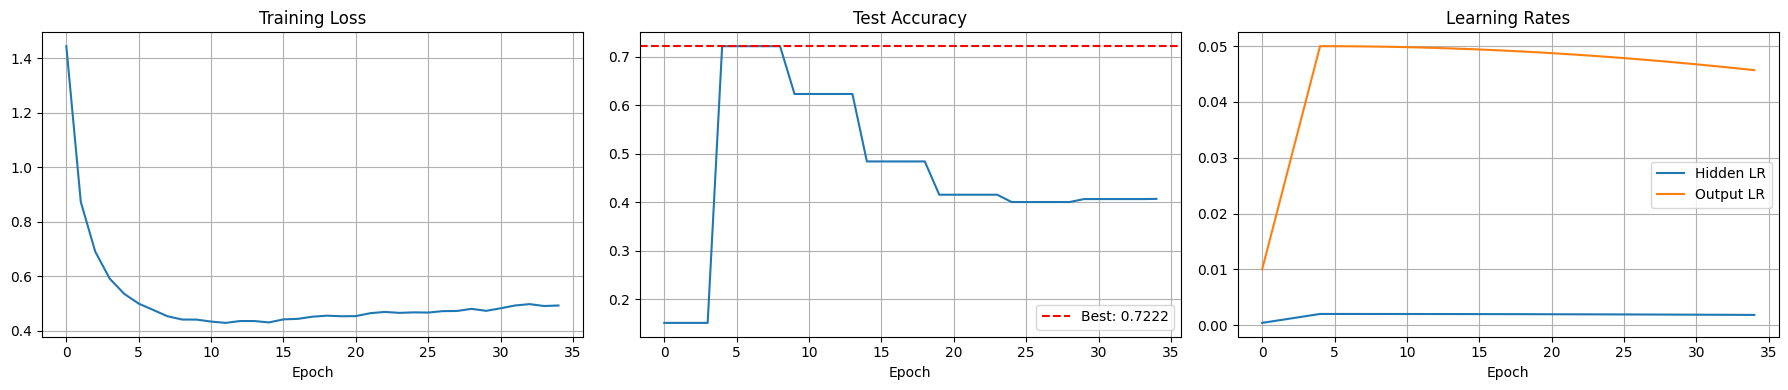

In [ ]:
# MNIST: 逆伝播なし（プロトタイプ局所学習）
# 過学習を抑制するため、ゲート機構を撤廃し、隠れ層にWeight Decayを導入
# 高速モード（GPU常駐データ＋GPU Aug）で実行
import math, time, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ===== ハイパラ (最終改善版) =====
use_cuda_if_available = True
epochs = 500
batch_size = 1024
eval_every = 5
early_stopping_patience = 30

# --- 学習率スケジューラ ---
lr_w_max = 2e-3
lr_w_min = 2e-4
lr_out_max = 5e-2
lr_out_min = 5e-3
warmup_epochs_lr = 5
decay_epochs_lr = 150           # AdamWの収束が速いため、冷却期間を少し短く戻す

# ★★★ 制御（正則化）の強化 ★★★
# --- 隠れ層 ---
lam_hidden = (0.1, 0.1, 0.1)      # ゲートがなくなったため、係数を固定値に
clip_norm = 1.0
weight_decay_hidden = 1e-5        # 隠れ層にWeight Decayを導入
# --- 出力層 (AdamW用) ---
weight_decay_out = 1e-4
# ★★★★★★★★★★★★★★★★★★★★★★★

# (ゲート機構の conf_thresh, cos_thresh は不要)
use_ema_eval = True
ema_decay = 0.999

# --- 我々の最適化 ---
target_modulation_alpha = 0.5

# --- その他 ---
proto_momentum = 0.99
temp_eval = 1.0
seed = 42

torch.manual_seed(seed); np.random.seed(seed)
device = "cuda" if (use_cuda_if_available and torch.cuda.is_available()) else "cpu"
torch.set_grad_enabled(False)

# 高速化スイッチ
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# ===== ユーティリティ =====
def get_learning_rate(epoch, warmup_epochs, decay_epochs, lr_max, lr_min):
    if epoch < warmup_epochs:
        return lr_max * (epoch / warmup_epochs)
    if epoch < warmup_epochs + decay_epochs:
        progress = (epoch - warmup_epochs) / decay_epochs
        cosine_decay = 0.5 * (1.0 + math.cos(math.pi * progress))
        return lr_min + (lr_max - lr_min) * cosine_decay
    return lr_min

def grad_clip_(G, max_norm):
    if max_norm is None or max_norm <= 0: return G
    gnorm = torch.linalg.vector_norm(G)
    if gnorm > max_norm: G = G * (max_norm / (gnorm + 1e-12))
    return G

# ===== モデル (変更なし) =====
class LocalConv(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, stride=1, padding=1):
        super().__init__()
        self.W = nn.Parameter(torch.empty(out_ch, in_ch, k, k))
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        self.stride, self.padding = stride, padding
        self.norm = nn.GroupNorm(8, out_ch)
    def forward(self, a_prev):
        z_pre = F.conv2d(a_prev, self.W, stride=self.stride, padding=self.padding)
        z = self.norm(z_pre)
        a = F.relu(z)
        return z, a

class LocalFC(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.empty(out_dim, in_dim))
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        self.norm = nn.LayerNorm(out_dim)
    def forward(self, a_prev):
        z_pre = F.linear(a_prev, self.W)
        z = self.norm(z_pre)
        a = F.relu(z)
        return z, a

class Net(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = LocalConv(1, 32, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = LocalConv(32, 64, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1   = LocalFC(64*7*7, 128)
        self.out   = nn.Linear(128, n_classes, bias=False)
    def forward(self, x):
        z1, a1 = self.conv1(x); a1p = self.pool1(a1)
        z2, a2 = self.conv2(a1p); a2p = self.pool2(a2)
        a2f = a2p.reshape(a2p.size(0), -1)
        z3, a3 = self.fc1(a2f)
        logits = self.out(a3)
        return (z1, z2, z3), (x, a1, a1p, a2, a2p, a2f, a3), logits

# ===== プロトタイプ (変更なし) =====
class ProtoBank:
    def __init__(self, dims, n_classes=10, momentum=0.99, device="cpu"):
        self.m = momentum
        self.P = {k: torch.zeros(n_classes, d, device=device) for k, d in dims.items()}
        self.init = {k: torch.zeros(n_classes, dtype=torch.bool, device=device) for k in dims.keys()}
    @torch.no_grad()
    def _upd(self, key, feats, y):
        Pk, Ik = self.P[key], self.init[key]
        for c in y.unique():
            c0 = int(c)
            m = (y==c)
            mu = feats[m].mean(0)
            if not Ik[c0]: Pk[c0] = mu; Ik[c0] = True
            else: Pk[c0] = self.m * Pk[c0] + (1 - self.m) * mu
        return Pk[y]
    def conv_target(self, key, Z, y):
        return self._upd(key, Z.mean((2,3)), y).unsqueeze(-1).unsqueeze(-1).expand_as(Z)
    def fc_target(self, key, Z, y):
        return self._upd(key, Z, y)

# ===== 損失関数 (変更なし) =====
def norm_mse_with_relu_mask(Z, U, z_for_mask):
    eps = 1e-6
    Zn = Z / (Z.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
    Un = U / (U.pow(2).sum(dim=1, keepdim=True).sqrt().clamp_min(eps))
    relu_mask = (z_for_mask > 0).float()
    E = (Zn - Un) * relu_mask
    L = 0.5 * (E.pow(2).mean())
    return E, L

# ===== EMAモデル (変更なし) =====
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow_params = [p.clone().detach() for p in model.parameters() if p.requires_grad]
    @torch.no_grad()
    def update(self, model):
        params = [p for p in model.parameters() if p.requires_grad]
        for s_param, param in zip(self.shadow_params, params):
            s_param.sub_((1. - self.decay) * (s_param - param))
    def copy_to(self, model):
        params = [p for p in model.parameters() if p.requires_grad]
        for s_param, param in zip(self.shadow_params, params):
            param.data.copy_(s_param.data)

# ===== 学習1ステップ (最終改善版) =====
@torch.no_grad()
def train_step(model, protos, feats, zs, y, lr_w,
               lam_hidden, target_modulation_alpha, weight_decay_hidden):
    (z1, z2, z3) = zs
    (x, a1, a1p, a2, a2p, a2f, a3) = feats

    # 1. 出力層の勾配計算 (更新はメインループのAdamW)
    logits = model.out(a3)
    prob = F.softmax(logits, dim=1)
    onehot = F.one_hot(y, num_classes=logits.shape[1]).float()
    ce_val = F.cross_entropy(logits, y).item()
    grad_logits = (prob - onehot) / logits.shape[0]
    dW_out = grad_logits.T @ a3
    model.out.weight.grad = dW_out

    # 2. プロトタイプ更新 & ターゲット変調
    U1 = protos.conv_target("c1", z1, y)
    U2 = protos.conv_target("c2", z2, y)
    U3_proto = protos.fc_target("fc1", z3, y)
    U3_topdown = model.out.weight.data[y]
    U3 = (1 - target_modulation_alpha) * U3_proto + target_modulation_alpha * U3_topdown

    # ★★★ ゲート機構を削除し、常に全データで隠れ層を学習 ★★★

    # 3. 隠れ層の更新
    lam1, lam2, lam3 = lam_hidden

    E1n, L1 = norm_mse_with_relu_mask(z1, U1, z_for_mask=z1)
    grad_like_1 = (lam1 * E1n) / x.size(0)
    dW1 = torch.nn.grad.conv2d_weight(x, model.conv1.W.shape, grad_like_1, stride=model.conv1.stride, padding=model.conv1.padding)
    dW1.add_(model.conv1.W.data, alpha=weight_decay_hidden) # ★ 隠れ層Weight Decay
    model.conv1.W.add_(-lr_w * grad_clip_(dW1, clip_norm))

    E2n, L2 = norm_mse_with_relu_mask(z2, U2, z_for_mask=z2)
    grad_like_2 = (lam2 * E2n) / x.size(0)
    dW2 = torch.nn.grad.conv2d_weight(a1p, model.conv2.W.shape, grad_like_2, stride=model.conv2.stride, padding=model.conv2.padding)
    dW2.add_(model.conv2.W.data, alpha=weight_decay_hidden) # ★ 隠れ層Weight Decay
    model.conv2.W.add_(-lr_w * grad_clip_(dW2, clip_norm))

    E3n, L3 = norm_mse_with_relu_mask(z3, U3, z_for_mask=z3)
    dW3 = ((lam3 * E3n) / x.size(0)).T @ a2f
    dW3.add_(model.fc1.W.data, alpha=weight_decay_hidden)   # ★ 隠れ層Weight Decay
    model.fc1.W.add_(-lr_w * grad_clip_(dW3, clip_norm))

    return ce_val + L1.item() + L2.item() + L3.item()

# ===== データ & 評価 (高速版) =====
@torch.no_grad()
def load_mnist_to_device(device):
    transform = transforms.ToTensor()
    ds_tr = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    ds_te = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    Xtr = torch.stack([x for x, y in ds_tr], dim=0).to(device)
    ytr = torch.tensor([y for x, y in ds_tr], device=device, dtype=torch.long)
    Xte = torch.stack([x for x, y in ds_te], dim=0).to(device)
    yte = torch.tensor([y for x, y in ds_te], device=device, dtype=torch.long)
    return Xtr, ytr, Xte, yte

@torch.no_grad()
def random_translate_gpu(x, max_shift=3): # データ拡張を少し強化
    B = x.size(0)
    tx = (torch.randint(-max_shift, max_shift+1, (B,), device=x.device, dtype=torch.float32)) / 14.0
    ty = (torch.randint(-max_shift, max_shift+1, (B,), device=x.device, dtype=torch.float32)) / 14.0
    theta = torch.zeros(B, 2, 3, device=x.device, dtype=torch.float32)
    theta[:,0,0] = 1.0; theta[:,1,1] = 1.0; theta[:,0,2] = tx; theta[:,1,2] = ty
    grid = F.affine_grid(theta, size=x.size(), align_corners=False)
    return F.grid_sample(x, grid, mode="bilinear", padding_mode="zeros", align_corners=False)

@torch.inference_mode()
def eval_accuracy(model, X, y, T=1.0, batch=4096):
    correct = 0
    for i in range(0, X.size(0), batch):
        xb = X[i:i+batch]
        _, _, logits = model(xb)
        if T != 1.0: logits = logits / T
        pred = logits.argmax(1)
        correct += (pred == y[i:i+batch]).sum().item()
    return correct / X.size(0)

# ===== 準備 =====
model = Net(n_classes=10).to(device)
optimizer_out = torch.optim.AdamW(model.out.parameters(), lr=lr_out_max, weight_decay=weight_decay_out)
ema = EMA(model, decay=ema_decay) if use_ema_eval else None
protos = ProtoBank({"c1":32,"c2":64,"fc1":128}, n_classes=10, momentum=proto_momentum, device=device)
Xtr, ytr, Xte, yte = load_mnist_to_device(device)

hist = {"train_loss": [], "test_acc": [], "lr_w": [], "lr_out": []}
print(f"device:{device} batch:{batch_size} epochs:{epochs}")
t0 = time.time()

best_test_acc = 0.0
patience_counter = 0
best_model_state = None

# ===== メインループ (最終改善版) =====
for ep in range(1, epochs+1):
    lr_w_current = get_learning_rate(ep, warmup_epochs_lr, decay_epochs_lr, lr_w_max, lr_w_min)
    lr_out_current = get_learning_rate(ep, warmup_epochs_lr, decay_epochs_lr, lr_out_max, lr_out_min)
    hist["lr_w"].append(lr_w_current); hist["lr_out"].append(lr_out_current)

    for param_group in optimizer_out.param_groups:
        param_group['lr'] = lr_out_current

    perm = torch.randperm(Xtr.size(0), device=device)
    running_loss, n = 0.0, 0
    for it in range(0, Xtr.size(0), batch_size):
        idx = perm[it:it+batch_size]
        xb, yb = Xtr[idx], ytr[idx]
        xb = random_translate_gpu(xb, max_shift=2)

        zs, feats, _ = model(xb)
        loss_batch = train_step(
            model, protos, feats, zs, yb, lr_w=lr_w_current,
            lam_hidden=lam_hidden, target_modulation_alpha=target_modulation_alpha,
            weight_decay_hidden=weight_decay_hidden
        )

        optimizer_out.step()
        optimizer_out.zero_grad()
        if ema: ema.update(model)

        running_loss += loss_batch * xb.size(0); n += xb.size(0)

    train_loss = running_loss / n
    hist["train_loss"].append(train_loss)

    if (ep % eval_every == 0) or (ep == 1) or (ep == epochs):
        eval_model = Net(n_classes=10).to(device)
        eval_model.load_state_dict(model.state_dict())
        if ema: ema.copy_to(eval_model)
        test_acc = eval_accuracy(eval_model, Xte, yte, T=temp_eval)
        del eval_model

        hist["test_acc"].append(test_acc)
        print_line = f"[epoch {ep:03d}] loss:{train_loss:.4f}  acc:{test_acc:.4f}  lr_w:{lr_w_current:.5f}  lr_out:{lr_out_current:.5f}"
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            patience_counter = 0
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
            if ema: best_ema_state = [p.clone() for p in ema.shadow_params]
            print(f"{print_line}  -> New best! Saved.")
        else:
            patience_counter += eval_every
            print(f"{print_line}  -> No improvement. Patience: {patience_counter}/{early_stopping_patience}.")

        if patience_counter >= early_stopping_patience and ep > warmup_epochs_lr:
            print(f"\nEarly stopping triggered.")
            break
    else:
        hist["test_acc"].append(hist["test_acc"][-1] if hist["test_acc"] else 0.0)
        print(f"[epoch {ep:03d}] loss:{train_loss:.4f}  (skipping eval)")

# ===== 学習終了処理 =====
print(f"\nTraining finished. Total elapsed: {time.time()-t0:.1f}s")
if best_model_state:
    print(f"Restoring model to best test accuracy: {best_test_acc:.4f}")
    model.load_state_dict(best_model_state)
    if ema and 'best_ema_state' in locals():
        ema.shadow_params = best_ema_state
        ema.copy_to(model)
else:
    print("No best model state was saved.")

final_acc = eval_accuracy(model, Xte, yte, T=temp_eval)
print(f"Final accuracy on test set after restoring best model: {final_acc:.4f}")

# ===== 可視化 =====
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes[0].plot(hist["train_loss"]); axes[0].set_title("Training Loss"); axes[0].set_xlabel("Epoch"); axes[0].grid(True)
axes[1].plot(hist["test_acc"]); axes[1].set_title("Test Accuracy"); axes[1].set_xlabel("Epoch"); axes[1].grid(True)
axes[1].axhline(y=best_test_acc, color='r', linestyle='--', label=f'Best: {best_test_acc:.4f}'); axes[1].legend()
axes[2].plot(hist["lr_w"], label="Hidden LR")
axes[2].plot(hist["lr_out"], label="Output LR")
axes[2].set_title("Learning Rates"); axes[2].set_xlabel("Epoch"); axes[2].grid(True); axes[2].legend()
plt.tight_layout()
plt.show()

#**Control: conventional CNN with backprop**

In [ ]:
# MNIST: 標準的な逆伝播（Backpropagation）での学習
# これまでの「逆伝播なし」版と同じアーキテクチャで性能を比較
# 高速化（GPU常駐データ＋GPU Aug）は維持
import math, time, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ===== ハイパラ =====
use_cuda_if_available = True
epochs = 100                    # 収束が速いのでエポック数は短めに設定
batch_size = 1024
learning_rate = 1e-3            # AdamW用の学習率
weight_decay = 1e-4

# (Early Stoppingは一旦削除し、まずは基本的な性能を確認)
# (学習率スケジューラも、まずは固定学習率で基本的な性能を確認)

seed = 42
torch.manual_seed(seed); np.random.seed(seed)
device = "cuda" if (use_cuda_if_available and torch.cuda.is_available()) else "cpu"
# ★★★ 逆伝播（自動微分）を有効化 ★★★
torch.set_grad_enabled(True)

# 高速化スイッチ
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# ===== モデル (同じアーキテクチャ) =====
# 内部実装をより標準的な書き方に変更
class Net(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(8, 32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(8, 64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.LayerNorm(128),
            nn.ReLU(inplace=True)
        )
        self.out = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc1(x)
        logits = self.out(x)
        return logits

# ===== データ & 評価 (変更なし) =====
@torch.no_grad()
def load_mnist_to_device(device):
    transform = transforms.ToTensor()
    ds_tr = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    ds_te = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    Xtr = torch.stack([x for x, y in ds_tr], dim=0).to(device)
    ytr = torch.tensor([y for x, y in ds_tr], device=device, dtype=torch.long)
    Xte = torch.stack([x for x, y in ds_te], dim=0).to(device)
    yte = torch.tensor([y for x, y in ds_te], device=device, dtype=torch.long)
    return Xtr, ytr, Xte, yte

@torch.no_grad()
def random_translate_gpu(x, max_shift=2):
    B = x.size(0)
    tx = (torch.randint(-max_shift, max_shift+1, (B,), device=x.device, dtype=torch.float32)) / 14.0
    ty = (torch.randint(-max_shift, max_shift+1, (B,), device=x.device, dtype=torch.float32)) / 14.0
    theta = torch.zeros(B, 2, 3, device=x.device, dtype=torch.float32)
    theta[:,0,0] = 1.0; theta[:,1,1] = 1.0; theta[:,0,2] = tx; theta[:,1,2] = ty
    grid = F.affine_grid(theta, size=x.size(), align_corners=False)
    return F.grid_sample(x, grid, mode="bilinear", padding_mode="zeros", align_corners=False)

@torch.inference_mode()
def eval_accuracy(model, X, y, batch=4096):
    model.eval() # 評価モードに切り替え
    correct = 0
    for i in range(0, X.size(0), batch):
        xb = X[i:i+batch]
        logits = model(xb)
        pred = logits.argmax(1)
        correct += (pred == y[i:i+batch]).sum().item()
    return correct / X.size(0)

# ===== 準備 =====
model = Net(n_classes=10).to(device)
Xtr, ytr, Xte, yte = load_mnist_to_device(device)

# ★★★ 標準的な損失関数とオプティマイザを定義 ★★★
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

hist = {"train_loss": [], "test_acc": [], "img_per_sec": []}

print(f"device:{device}  batch:{batch_size}  epochs:{epochs} (Standard Backpropagation)")
t0 = time.time()

# ===== メインループ (標準的な逆伝播) =====
for ep in range(1, epochs+1):
    model.train() # 学習モードに切り替え
    perm = torch.randperm(Xtr.size(0), device=device)
    if device == "cuda": torch.cuda.synchronize()
    epoch0 = time.time()

    running_loss, n = 0.0, 0
    for it in range(0, Xtr.size(0), batch_size):
        idx = perm[it:it+batch_size]
        xb, yb = Xtr[idx], ytr[idx]
        xb = random_translate_gpu(xb, max_shift=2)

        # 1. 勾配をリセット
        optimizer.zero_grad()

        # 2. フォワードパス
        logits = model(xb)

        # 3. 損失を計算
        loss = criterion(logits, yb)

        # 4. 逆伝播（勾配計算）
        loss.backward()

        # 5. 重みを更新
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        n += xb.size(0)

    train_loss = running_loss / n
    test_acc = eval_accuracy(model, Xte, yte)

    if device == "cuda": torch.cuda.synchronize()
    dt = time.time() - epoch0
    ips = n / dt

    hist["train_loss"].append(train_loss)
    hist["test_acc"].append(test_acc)
    hist["img_per_sec"].append(ips)

    print(f"[epoch {ep:03d}] loss:{train_loss:.4f}  test_acc:{test_acc:.4f}  ({ips:.0f} img/s)")

print(f"\nTraining finished. Total elapsed: {time.time()-t0:.1f}s")
print(f"Final test accuracy: {hist['test_acc'][-1]:.4f}")

# ===== 可視化 =====
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes[0].plot(hist["train_loss"]); axes[0].set_title("Training Loss"); axes[0].set_xlabel("Epoch"); axes[0].grid(True)
axes[1].plot(hist["test_acc"]); axes[1].set_title("Test Accuracy"); axes[1].set_xlabel("Epoch"); axes[1].grid(True)
axes[2].plot(hist["img_per_sec"]); axes[2].set_title("Throughput (img/s)"); axes[2].set_xlabel("Epoch"); axes[2].grid(True)
plt.tight_layout()
plt.show()